<a href="https://colab.research.google.com/github/Deepthishanmugam/Sales_Forecasting/blob/main/Copy_of_Portfolio_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [429]:
!pip install pmdarima
!pip install scikit-optimize

In [430]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import gdown

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA

from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from pmdarima import auto_arima
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.plots import plot_convergence

import xgboost as xgb
from xgboost import plot_importance

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [431]:
!gdown "https://drive.google.com/drive/folders/1fBQ1PlWMho3kHF9qXrD0McZNfpJIcbrn"

/usr/local/lib/python3.11/dist-packages/gdown/parse_url.py:48: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None
  warnings.warn(
Downloading...
From: https://drive.google.com/drive/folders/1fBQ1PlWMho3kHF9qXrD0McZNfpJIcbrn
To: /content/1fBQ1PlWMho3kHF9qXrD0McZNfpJIcbrn
1.23MB [00:00, 32.5MB/s]


In [432]:
with open('/content/1fBQ1PlWMho3kHF9qXrD0McZNfpJIcbrn', 'r') as file:
    content = file.read()

In [433]:
import gdown

# Define the file IDs
file_ids = [
    "1ditFn_74EOsGnblf2nXr-Vx-I1mrCG42",
    "1CclWDHsFLfCAuBbAv83_D5_XmeoRwWzl"
]

# Download each file
for file_id in file_ids:
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1ditFn_74EOsGnblf2nXr-Vx-I1mrCG42
To: /content/TRAIN.csv
100%|██████████| 9.33M/9.33M [00:00<00:00, 107MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CclWDHsFLfCAuBbAv83_D5_XmeoRwWzl
To: /content/TEST_FINAL.csv
100%|██████████| 849k/849k [00:00<00:00, 20.6MB/s]


In [434]:
df1 = pd.read_csv('TRAIN.csv')
df1.head()
dt = df = df1

In [435]:
df2 = pd.read_csv('TEST_FINAL.csv')
df2.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount
0,T1188341,171,S4,L2,R3,2019-06-01,0,No
1,T1188342,172,S1,L1,R1,2019-06-01,0,No
2,T1188343,173,S4,L2,R1,2019-06-01,0,No
3,T1188344,174,S1,L1,R4,2019-06-01,0,No
4,T1188345,170,S1,L1,R2,2019-06-01,0,No


###**Data Cleaning:     Address missing values, remove duplicates, and correct inconsistencies in the dataset.**

Data cleaning is an essential step in data preprocessing that involves preparing a dataset for analysis by addressing issues such as missing values, duplicates, and inconsistencies.

**Addressing Missing Values :**

 *Purpose*   :
  
  - Since missing data can lead to inaccurate analysis and misleading results we are addressing Missing values.

*Implementation*   :
 - By removing or Imputing the missing values

Given **`Data has No Missing Values`**



In [436]:
# Check for missing values
print("Missing values in each column:")
print(df1.isnull().sum())

Missing values in each column:
ID               0
Store_id         0
Store_Type       0
Location_Type    0
Region_Code      0
Date             0
Holiday          0
Discount         0
#Order           0
Sales            0
dtype: int64


**Removing Duplicates :**

 *Purpose*   :
  
  - Duplicates can skew the analysis, leading to overrepresentation of certain data points or incorrect conclusions.

*Implementation*   :
 - By removing dupicates

Given **`Data has No Duplicate Values`**



In [437]:
# Check if there are any duplicate rows
print("\nDuplicate rows:")
print(df1.duplicated().sum())


Duplicate rows:
0


**Correcting Inconsistencies :**

 *Purpose*   :
  
  - Inconsistencies, such as typos, different units of measurement, or varied formatting, can lead to incorrect analysis.

*Implementation*   :
 - By Standardizing formats

In Given **`Data Sales & Date columns are standardised`**



In [438]:
# Ensuring Sales is a numeric column
df1['Sales'] = pd.to_numeric(df1['Sales'], errors='coerce')

# Ensuring Date column is of datetime type
df1['Date'] = pd.to_datetime(df1['Date'])

df1.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52


###**Feature Engineering:**

Developing new features that could enhance the model's predictive power, such as time-based aggregates (e.g., sales in the last week), ratios, or interaction terms between features.


Feature engineering is the process of creating new features from the existing data to improve the performance of machine learning models. The goal is to make the model better at capturing patterns and relationships.


**Time-Based Aggregates:**

 *Purpose*   :
  
  - Creating time-based features helps the model recognize trends or seasonal patterns.

*Implementation*   :
 - By identifying Time periods such as days of weeks etc.

**Sales per Order:**

 *Purpose*   :
  
  - Creating this feature helps to identify individual sales for each order

*Implementation*   :
 - By identifying new feature derived by doing a ratio

**Create a Rolling Average of Sales:**

 *Purpose*   :
  
  - A rolling average smooths out helps identify longer-term trends, making it useful for time-series analysis.

*Implementation*   :
 -  for each day, the average sales of the previous 7 days is calculated, including that day. This helps reduce the impact of daily volatility

**Discount Effectiveness:**

 *Purpose*   :
  
  - Discounts often affect sales, and this feature can help the model understand if the increase (or decrease) in sales is due to the discount.

*Implementation*   :
 -  Implementing a simple flag that indicates whether a discount was offered during a given period.

In [439]:
# Time-Based Aggregates: Extract Month and Day of Week
df1['Month'] = df1['Date'].dt.month
df1['Day_of_Week'] = df1['Date'].dt.dayofweek  # Monday = 0, Sunday = 6
df1.head()

# Feature for Sales per Order
df1['Sales_per_Order'] = df1['Sales'] / df1['#Order']

# Rolling Average of Sales (7-day rolling window)
df1['Sales_Rolling_7'] = df1['Sales'].rolling(window=7, min_periods=1).mean()


# Discount Effectiveness
df1['Discount_Active'] = df1['Discount'].apply(lambda x: 1 if x == 'Yes' else 0)


**Interaction Term:**

 *Purpose*   :
  
  - It allows the model to capture how the combined effect of these features might influence the target variable.

*Implementation*   :
 -  It is implemented by combining the Store_Type and Region_Code variables.


**Lagged Features :**

 *Purpose*   :
  
  - Lagged features help the model use past data to predict future events.

*Implementation*   :
 -  By creating a new feature that represents the sales from a previous time period, the previous day

**Rolling Window:**

 *Purpose*   :
  
  - A rolling sum can provide a sense of the cumulative sales activity over a longer period.

*Implementation*   :
 -  For each day, calculating the sum of sales for the past 30 days, including the current day

**Total Orders per Store:**

 *Purpose*   :
  
  - Aggregating by Store Type can help capture the overall performance and behavior of each store type

*Implementation*   :
 -  This basically aggregates the total number of orders for each store type

In [440]:
# Interaction term
df1['Store_Type_Region_Interaction'] = df1['Store_Type'] + "_" + df1['Region_Code']

# Lagged Features (previous day sales)
df1['Lagged_Sales'] = df1['Sales'].shift(1)  # Previous day's sales


# Rolling Window: Sum of sales for the past 30 days
df1['Sales_Rolling_30'] = df1['Sales'].rolling(window=30, min_periods=1).sum()

# Total Orders per Store Type
df1['Total_Orders_by_Store_Type'] = df1.groupby('Store_Type')['#Order'].transform('sum')
df1.head()


,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales,Month,Day_of_Week,Sales_per_Order,Sales_Rolling_7,Discount_Active,Store_Type_Region_Interaction,Lagged_Sales,Sales_Rolling_30,Total_Orders_by_Store_Type
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84,1,0,779.093333,7011.840,1,S1_R1,NaN,7011.84,5149577
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12,1,0,863.152000,29400.480,1,S4_R1,7011.84,58800.96,4702286
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20,1,0,877.814286,31889.720,1,S3_R1,51789.12,95669.16,1824495
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16,1,0,857.180870,28846.080,1,S2_R1,36868.20,115384.32,1169502
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52,1,0,735.718065,32199.768,1,S2_R4,19715.16,160998.84,1169502


###**Data Transformation:**

Scale numerical features and encode categorical variables to prepare the data for modeling. Techniques like normalization or standardization and one-hot encoding or label encoding can be applied.

Data transformation is a crucial step in data preprocessing that prepares raw data for modeling. This process involves scaling numerical features and encoding categorical variables so that they are in a suitable form for machine learning algorithms.


**Scaling Numerical Features:**

 *Purpose*   :
  
  - If numerical features are not scaled models may give disproportionate weight to larger values, leading to biased or inefficient learning.


*Implementation*   :
 -  Done using Normalization & Standardization

**Encoding Categorical Variables:**

 *Purpose*   :
  
  - Many machine learning algorithms cannot directly work with categorical variables, so these variables are converted into a numerical format so that the model can process them.


*Implementation*   :
 -  Done using One-Hot Encoding that creates binary columns for each category in the feature.


Further, Data is splitted into train-test split, where a dataset is divided into two subsets: one for training the model and the other for testing its performance. which helps assess how well the model generalizes to new, unseen data and prevents overfitting.


In [441]:
df1.columns

Index(['ID', 'Store_id', 'Store_Type', 'Location_Type', 'Region_Code', 'Date',
       'Holiday', 'Discount', '#Order', 'Sales', 'Month', 'Day_of_Week',
       'Sales_per_Order', 'Sales_Rolling_7', 'Discount_Active',
       'Store_Type_Region_Interaction', 'Lagged_Sales', 'Sales_Rolling_30',
       'Total_Orders_by_Store_Type'],
      dtype='object')

In [442]:
# Encoding Categorical Variables
df_encoded = pd.get_dummies(df1, columns=['Store_Type', 'Location_Type', 'Region_Code', 'Discount', 'Store_Type_Region_Interaction'], drop_first=True)

# Scale Numerical Features
scaler = StandardScaler()
df_encoded[['Sales', '#Order']] = scaler.fit_transform(df_encoded[['Sales', '#Order']])
# After encoding and scaling
print("\nData after transformation:")
print(df_encoded.head(2))


Data after transformation:
         ID  Store_id       Date  Holiday    #Order     Sales  Month  \
0  T1000001         1 2018-01-01        1 -1.943251 -1.938189      1   
1  T1000002       253 2018-01-01        1 -0.269328  0.487889      1   

   Day_of_Week  Sales_per_Order  Sales_Rolling_7  ...  \
0            0       779.093333          7011.84  ...   
1            0       863.152000         29400.48  ...   

   Store_Type_Region_Interaction_S2_R3  Store_Type_Region_Interaction_S2_R4  \
0                                False                                False   
1                                False                                False   

   Store_Type_Region_Interaction_S3_R1  Store_Type_Region_Interaction_S3_R2  \
0                                False                                False   
1                                False                                False   

   Store_Type_Region_Interaction_S3_R3  Store_Type_Region_Interaction_S3_R4  \
0                           


###**Train-Test Split: Divide the data into training and testing sets to ensure the model can be objectively evaluated.**

The train-test split is a fundamental technique used in machine learning used to evaluate the performance of a model.


**Training Set:**

 *Purpose*   :
  
  - This portion of the data is used to train the model, i.e., to learn patterns and make predictions.


**Test Set:**

 *Purpose*   :
  
  - This portion is used to evaluate the model's performance after training, giving an unbiased estimate of how well the model will perform on new, unseen data.


*Implementation*   :
 -  Splitting the data in ration 80:20 for training and testing and implementing train_test_split method accordingly.

In [443]:
# Assuming df_encoded is the transformed dataset after scaling and encoding
# Define the features (X) and target variable (y)
X = df_encoded.drop(columns=['Sales', 'ID', 'Date'])
y = df_encoded['Sales']

# Perform train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)
print("Training Target Shape:", y_train.shape)
print("Testing Target Shape:", y_test.shape)




Training Features Shape: (150672, 37)
Testing Features Shape: (37668, 37)
Training Target Shape: (150672,)
Testing Target Shape: (37668,)


###**2. Model Selection**
Model selection is a critical step in the machine learning pipeline where we choose the appropriate model (algorithm) to solve the problem. It involves evaluating and selecting the best model based on its performance on the data. The process requires balancing factors such as accuracy, complexity, interpretability, and training time, among others.


 **Why Model Selection?**

 To address below
  - Performance Variability
  - Trade-offs
  - Generalization

###**Baseline Model: Starting with a simple model to establish a baseline performance. Linear regression is a common choice.**

A baseline model is a simple model that is easy to implement and provides a starting point for assessing the performance of more complex models. It gives us an initial benchmark that helps understanding the "minimum" performance we should expect. Below are the main purpose of it,
 - Initial Performance Estimate
 - Quick Evaluation
 - Avoid Overfitting



 **Why Linear Regression?**

 *Purpose*   :
  
  - Linear regression is one of the simplest models and assumes a linear relationship between the input features and the target variable which will be ease for implementation.
  Since the coefficients of a linear regression model directly indicate the relationship between each feature and the target. This makes it easier to explain the results. Additionally its Quick to Train


*Implementation*   :
 -  By providing Train & Test data as input model makes the prediction by making the values fit a straight line.

         R-squared (0.92): The Linear Regression model explains 92% of the variance in the target variable, indicating a strong fit and good predictive power.
         Mean Absolute Error (3678.6): On average, the model's predictions are off by 3678.6, which is acceptable based on the scale of the sales data


In [444]:
df1 = pd.read_csv('TRAIN.csv')
df1.head()
dt = df1

In [445]:
dt['Date'] = pd.to_datetime(dt['Date'])
dt['month'] = dt['Date'].dt.month
dt.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales,month
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84,1
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12,1
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20,1
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16,1
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52,1


In [446]:
# Assuming the original dataframe dt
# Encoding Categorical Features using One-Hot Encoding
df_encoded = pd.get_dummies(dt, columns=['Store_Type', 'Location_Type', 'Region_Code', 'Discount'], drop_first=True)

# Define Features (X) and Target (y)
X = df_encoded.drop(columns=['Sales', 'ID', 'Date'])
y = df_encoded['Sales']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make]ing predictions
y_pred = model.predict(X_test)

# Evaluation metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Output the evaluation metrics
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

R-squared: 0.9234
Mean Absolute Error: 3678.6912


**Feature vs. Target (Sales)**

 *Purpose*   :
  
  - This scatter plot visualizes the relationship between one feature (in this case, #Order) and the target variable (Sales). we can compare how well the model's predictions align with the actual sales.

*Interpretation*   :

- If the red points (predicted sales) are close to the blue points (actual sales), it indicates a good model fit.



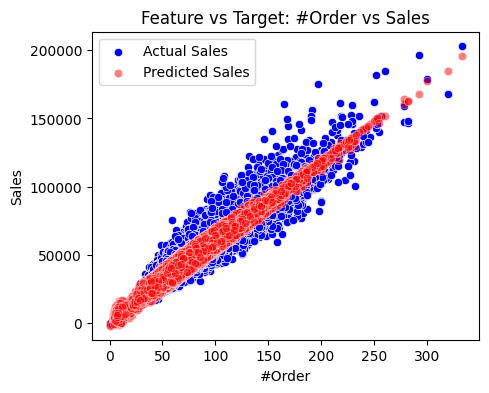

In [447]:
plt.figure(figsize=(5, 4))
sns.scatterplot(x=X_test['#Order'], y=y_test, label="Actual Sales", color='blue')
sns.scatterplot(x=X_test['#Order'], y=y_pred, label="Predicted Sales", color='red', alpha=0.5)
plt.title('Feature vs Target: #Order vs Sales')
plt.xlabel('#Order')
plt.ylabel('Sales')
plt.legend()
plt.show()

**Actual vs. Predicted Values**

 *Purpose*   :
  
  - This scatter plot compares the actual Sales values (y_test) against the predicted values (y_pred).

*Interpretation*   :

- Ideally, the points should lie along the diagonal line, which represents the case where predicted values are equal to actual values. Any significant deviation from this line indicates a higher error.




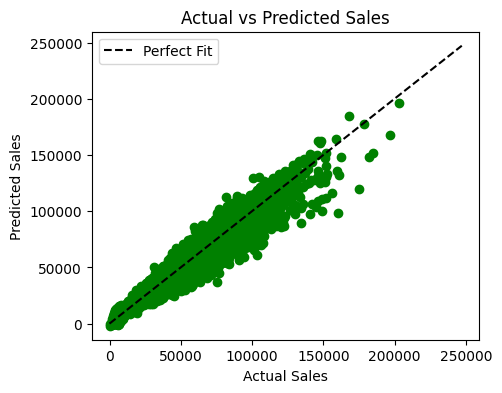

In [448]:
# Actual vs Predicted Values
plt.figure(figsize=(5, 4))
plt.scatter(y_test, y_pred, color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--k', label='Perfect Fit')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.show()

**Residual Plot (Error Plot)**

 *Purpose*   :
  
  - A residual plot shows the difference between the actual and predicted values. It's helpful to evaluate if the model's errors are randomly distributed.

*Interpretation*   :

- If the residuals are randomly dispersed around zero, this suggests that the model has captured the underlying patterns well. Any clear patterns or trends in the residuals could indicate that the model needs improvement.



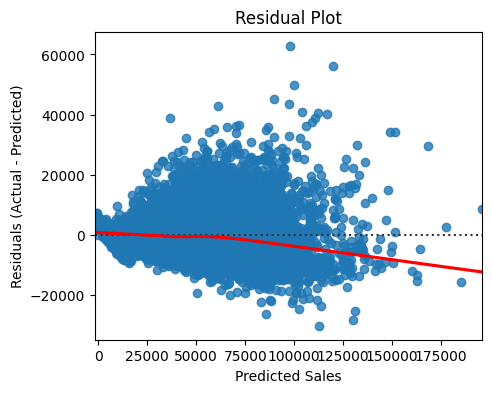

In [449]:
# Residual Plot (Error Plot)
residuals = y_test - y_pred
plt.figure(figsize=(5, 4))
sns.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.title('Residual Plot')
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals (Actual - Predicted)')
plt.show()

**Model Performance Metrics**

 *Purpose*   :
  
  - A bar plot showing the key evaluation metrics (R-squared and MAE).

*Interpretation*   :

- This gives a quick overview of the model's performance. High R-squared indicates that the model explains a large portion of the variance in sales, while MAE gives a sense of the average prediction error.



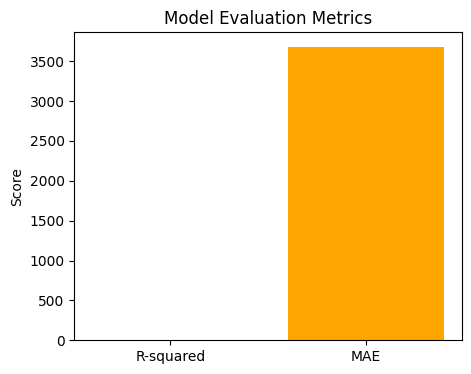

In [450]:
# Model Performance Metrics Bar Plot
metrics = {'R-squared': r2, 'MAE': mae}
plt.figure(figsize=(5, 4))
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'orange'])
plt.title('Model Evaluation Metrics')
plt.ylabel('Score')
plt.show()

###**Complex Models: Explore more sophisticated models to improve accuracy. Potential models include:**

These models are often more powerful and flexible, capable of capturing complex patterns and relationships in the data. The goal is to improve accuracy and enhance the model's predictive power by moving beyond the basic approach. Below are the main purpose of it,
 - Better Accuracy
 - Non-linearity
 - Flexibility
 - Handling More Complex Data






**Implementation**
 -  By providing Train & Test data as input model makes the prediction by making the values fit a straight line.

###**1. Time Series Model: Applying ARIMA for data forecasting:**

 *Purpose*:

  ARIMA (AutoRegressive Integrated Moving Average) is one of the most widely used models for forecasting time series data.
 - It is particularly effective when the data shows trends or seasonality and is based on past observations.
 - ARIMA helps predict future values by analyzing past values (autoregressive), the differences between consecutive values (integrated), and the moving average of past errors.

*Components:*

 The ARIMA model is denoted as ARIMA(p, d, q), where:
 - p is the number of lag observations in the autoregressive part (AR).
 - d is the number of times the data is differenced to make it stationary.
 - q is the size of the moving average window (MA).

Once the model is fitted it can be used to make predictions and forecasts.

In [451]:
dt.head()


,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales,month
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84,1
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12,1
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20,1
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16,1
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52,1


In [452]:
# Ensuring the date format
df_model = dt
df_model['Date'] = pd.to_datetime(df_model['Date'])
df_model.set_index('Date', inplace=True)

In [453]:
# Preparing data for stationary tests
date_range = df_model.index
sales_data = df_model['Sales']
data = pd.DataFrame({'date': date_range, 'Sales': sales_data})
data.index = pd.to_datetime(data['date'])
data = data.groupby(data.index).median()
data = data.drop('date', axis=1)
data

,Sales
date,
2018-01-01,39982.38
2018-01-02,50628.00
2018-01-03,47988.00
2018-01-04,52410.00
2018-01-05,60078.00
...,...
2019-05-27,43821.00
2019-05-28,47451.00
2019-05-29,42933.00


####**Dickey-Fuller test**

 - Using statistical analysis - Dickey-Fuller Test we can determine whether a given time series is stationary or non-stationary.

 - In time series analysis, we will find stationarity(constant over time) / non-stationary(show trends or seasonality, which need to be addressed before modeling.)

In [454]:
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] < 0.05:
      print("Reject the null hypothesis: The series is stationary.")
    else:
      print("Fail to reject the null hypothesis: The series is non-stationary.")

adf_test(data['Sales'])

ADF Statistic: -3.4590273622955423
p-value: 0.009103860345178972
Critical Values:
	1%: -3.4436029548776395
	5%: -2.867384756137026
	10%: -2.5698830308597813
Reject the null hypothesis: The series is stationary.


####**Differencing**

From the data considered the series was already stationary, still the differencing is done and got the below p-values and other factors,



```
ADF Statistic: -3.4590273622955423
p-value: 0.009103860345178972
Critical Values:
	1%: -3.4436029548776395
	5%: -2.867384756137026
	10%: -2.5698830308597813
```



- Using Differencing technique for time series analysis to transform a non-stationary series into a stationary one.
- Differencing helps to remove trends and seasonality from a time series, making it more suitable for modeling.


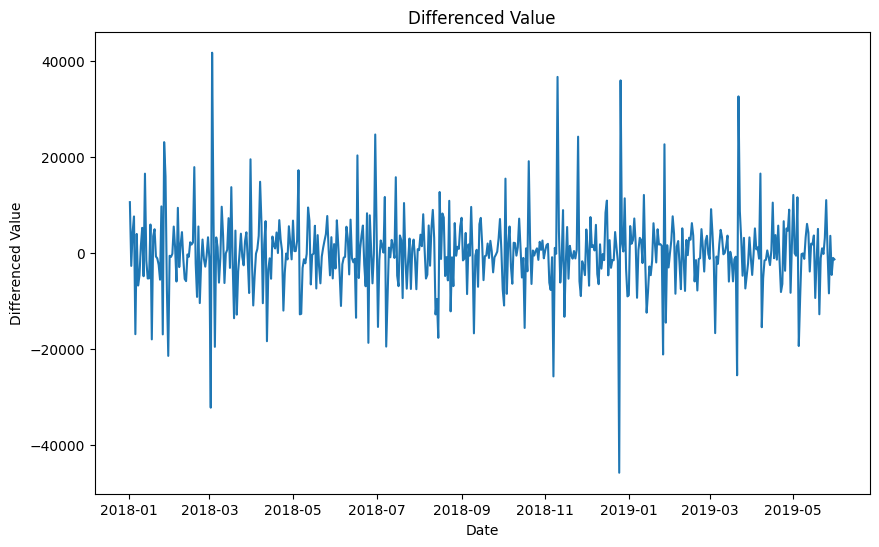

ADF Statistic: -9.26720946595902
p-value: 1.3568130861411842e-15
Critical Values:
	1%: -3.4436298692815304
	5%: -2.867396599893435
	10%: -2.5698893429241916
Reject the null hypothesis: The series is stationary.


In [455]:
# Although the series is stationary below differencing & decomposition models are done for reference

# Differencing to make the series stationary
data['Value_diff'] = data['Sales'] - data['Sales'].shift(1)

# Drop NaN values after differencing
data.dropna(inplace=True)

# Plot the differenced series
plt.figure(figsize=(10, 6))
plt.plot(data['Value_diff'])
plt.title('Differenced Value')
plt.xlabel('Date')
plt.ylabel('Differenced Value')
plt.show()

# Check stationarity again
adf_test(data['Value_diff'])


####**Decomposition**


- Time series decomposition is helps to understand the underlying patterns and improving forecasting accuracy & improve decision-making..
- where the time series split into components: trend, seasonality, and residual (or noise).


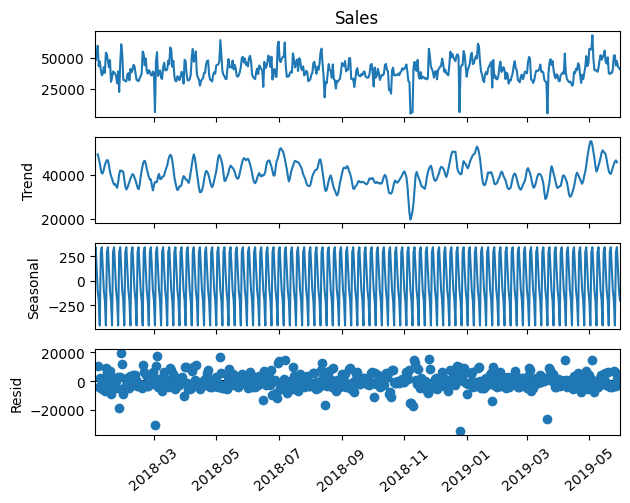

In [456]:
# Decomposition and its vizualisation
result = seasonal_decompose(data['Sales'], model='additive', period=6)
result.plot()
plt.xticks(rotation = 40)
plt.show()

####**ACF and PACF**

- In order to understand the relationships between an observation and its past values &
- Identifying appropriate time series models & understanding the structure of the data below plots are implemented.

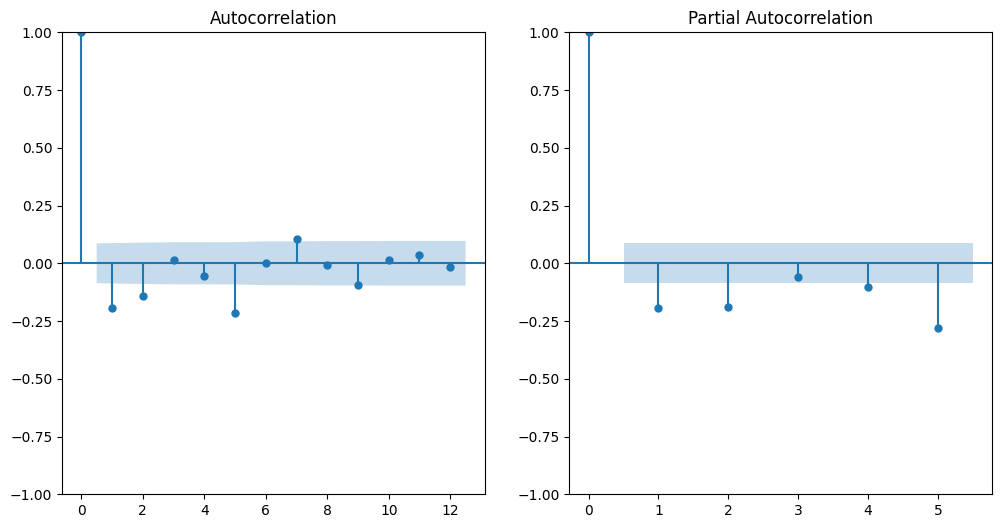

In [457]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_acf(data['Value_diff'], lags=12, ax=plt.gca())

plt.subplot(122)
plot_pacf(data['Value_diff'], lags=5, ax=plt.gca())

plt.show()

In [458]:
# Perform Augmented Dickey-Fuller test
result = adfuller(data['Sales'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -3.461280550155466
p-value: 0.009038986906826817


###**Executing ARIMA model**

In [459]:
# Fit AutoARIMA model
model_autoarima = auto_arima(data['Sales'], seasonal=False, stepwise=True, trace=True)

# Print the best model
print(model_autoarima.summary())

# Forecast next 6 periods
forecast_autoarima = model_autoarima.predict(n_periods=6)
print("AutoARIMA forecast:", forecast_autoarima)


Performing stepwise search to minimize aic


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all

 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12404.057, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=10723.584, Time=0.05 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,1)(0,0,0)[0]             : AIC=11842.168, Time=0.34 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,0,0)(0,0,0)[0]             : AIC=10707.362, Time=0.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.80 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,0,1)(0,0,0)[0]             : AIC=10617.903, Time=1.85 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(0,0,0)[0]             : AIC=10696.921, Time=0.38 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=2.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,2)(0,0,0)[0]             : AIC=10635.299, Time=0.28 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(3,0,2)(0,0,0)[0]             : AIC=10684.822, Time=1.22 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=10601.349, Time=0.21 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=10599.457, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=10641.344, Time=0.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=10597.972, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=10786.338, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=10599.342, Time=0.12 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 8.919 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  515
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -5295.986
Date:                Sat, 01 Feb 2025   AIC                          10597.972
Time:                        19:05:17   BIC                          10610.704
Sample:                    01-02-2018   HQIC                         10602.962
                         - 05-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



AutoARIMA forecast: 2019-06-01    40446.060372
2019-06-02    40317.520988
2019-06-03    40246.014020
2019-06-04    40206.234412
2019-06-05    40184.104858
2019-06-06    40171.794100
Freq: D, dtype: float64


####***Vizual representation of ARIMA forecast***

<ipython-input-460-520b3fd30881>:2: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



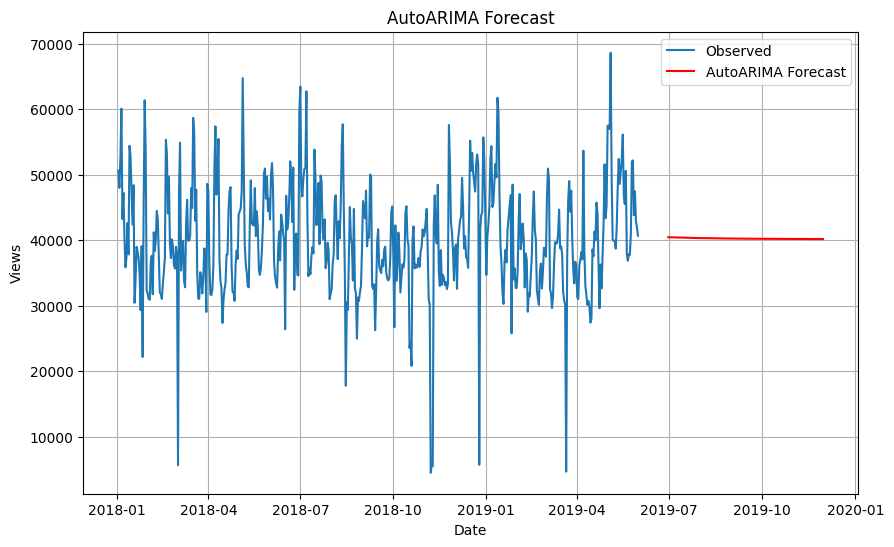

In [460]:
# Create a new time index for the forecasted period
forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=30), periods=6, freq='M')

# Plot the results
plt.figure(figsize=(10, 6))

# Plot historical data
plt.plot(data.index, data['Sales'], label='Observed')

# Plot forecasted data
plt.plot(forecast_index, forecast_autoarima, label='AutoARIMA Forecast', color='red')

# Add labels and legend
plt.title('AutoARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Views')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the 

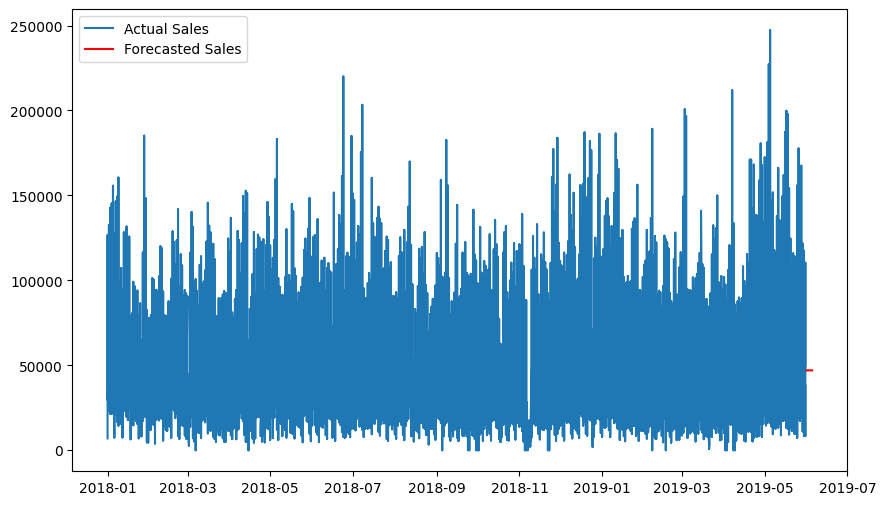

In [461]:
#dt['month'] = pd.to_datetime(dt['month'])
#dt.set_index('month', inplace=True)
sales = dt['Sales']

# Fit an ARIMA model (order=(p, d, q))
# p = lag order, d = differencing order, q = order of moving average
model = ARIMA(sales, order=(1, 1, 1))
model_fit = model.fit()

# Make predictions
forecast = model_fit.forecast(steps=5)

# Plot for actual vs. forecasted sales
plt.figure(figsize=(10,6))
plt.plot(sales, label='Actual Sales')
plt.plot(pd.date_range(sales.index[-1], periods=6, freq='D')[1:], forecast, label='Forecasted Sales', color='red')
plt.legend()
plt.show()


##**SARIMA**

 - SARIMA (Seasonal AutoRegressive Integrated Moving Average) an extension of the ARIMA model which explicitly accounts for seasonality in time series data.

 - It is mainly used to model time series data that exhibits both non-seasonal and seasonal behaviors using components such as (AutoRegressive, Integrated, Moving Average & Seasonality)

In [462]:
# Aggregate duplicates
date_range = df_model.index
sales_data = df_model['Sales']
data = pd.DataFrame({'date': date_range, 'Sales': sales_data})
data.index = pd.to_datetime(data['date'])
data = data.groupby(data.index).median()
data = data.drop('date', axis=1)
data

,Sales
date,
2018-01-01,39982.38
2018-01-02,50628.00
2018-01-03,47988.00
2018-01-04,52410.00
2018-01-05,60078.00
...,...
2019-05-27,43821.00
2019-05-28,47451.00
2019-05-29,42933.00



####**Dickey-Fuller test**

 - Using statistical analysis - Dickey-Fuller Test we can determine whether a given time series is stationary or non-stationary.

 - In time series analysis, we will find stationarity(constant over time) / non-stationary(show trends or seasonality, which need to be addressed before modeling.)


In [463]:
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

adf_test(data['Sales'])

if result[1] < 0.05:
    print("Reject the null hypothesis: The series is stationary.")
else:
    print("Fail to reject the null hypothesis: The series is non-stationary.")


ADF Statistic: -3.4590273622955423
p-value: 0.009103860345178972
Critical Values:
	1%: -3.4436029548776395
	5%: -2.867384756137026
	10%: -2.5698830308597813
Reject the null hypothesis: The series is stationary.


####**Differencing**


- Using Differencing technique for time series analysis to transform a non-stationary series into a stationary one.
- Differencing helps to remove trends and seasonality from a time series, making it more suitable for modeling.

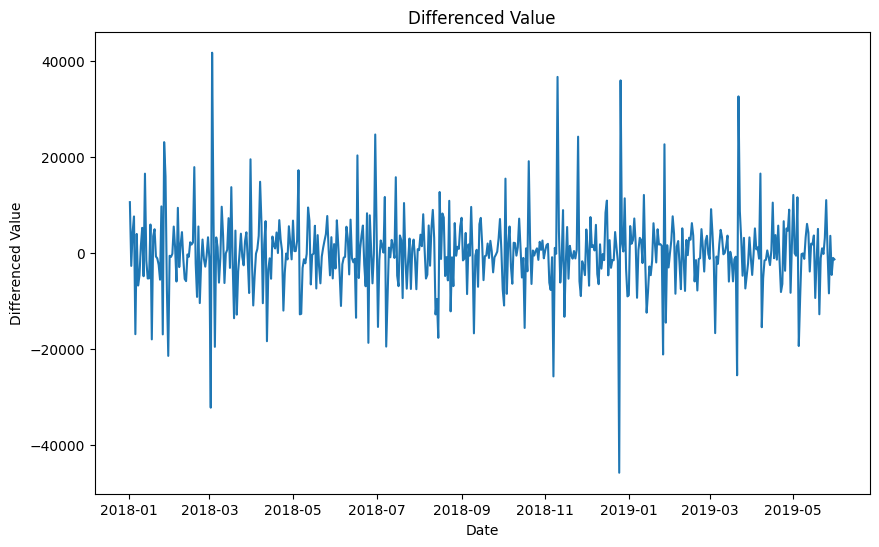

ADF Statistic: -9.26720946595902
p-value: 1.3568130861411842e-15
Critical Values:
	1%: -3.4436298692815304
	5%: -2.867396599893435
	10%: -2.5698893429241916


In [464]:
# Differencing to make the series stationary
data['Value_diff'] = data['Sales'] - data['Sales'].shift(1)

# Drop NaN values after differencing
data.dropna(inplace=True)

# Plot the differenced series
plt.figure(figsize=(10, 6))
plt.plot(data['Value_diff'])
plt.title('Differenced Value')
plt.xlabel('Date')
plt.ylabel('Differenced Value')
plt.show()

# Check stationarity again
adf_test(data['Value_diff'])


####**Decomposition**

- Time series decomposition is helps to understand the underlying patterns and improving forecasting accuracy.
- where the time series split into components: trend, seasonality, and residual (or noise).


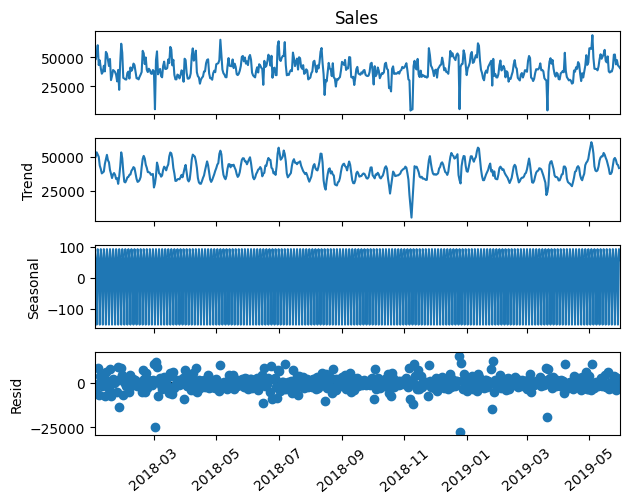

In [465]:
# Decomposition and its vizualisation
result = seasonal_decompose(data['Sales'], model='additive', period=3)
result.plot()
plt.xticks(rotation = 40)
plt.show()

####**ACF and PACF**

- In order to understand the relationships between an observation and its past values &
- Identifying appropriate time series models (like ARIMA) & understanding the structure of the data below plots are implemented.

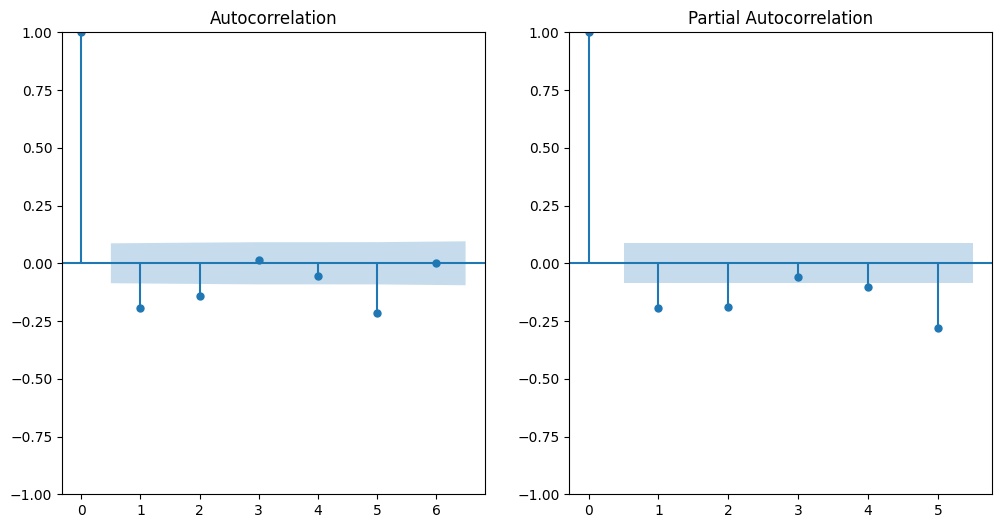

In [466]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_acf(data['Value_diff'], lags=6, ax=plt.gca())

plt.subplot(122)
plot_pacf(data['Value_diff'], lags=5, ax=plt.gca())

plt.show()


###**Executing SARIMAX model**

In [467]:
# Fit SARIMAX model with exogenous variable
model = SARIMAX(data['Sales'], exog=data['Value_diff'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)

# Print the summary of the model
print(model_fit.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  515
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4999.586
Date:                            Sat, 01 Feb 2025   AIC                          10011.172
Time:                                    19:05:52   BIC                          10036.483
Sample:                                01-02-2018   HQIC                         10021.102
                                     - 05-31-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Value_diff     0.4978      0.015     33.786      0.000       0.469       0.527
ar.L1         -0.2803      0.115   

In [468]:
model_sarima = SARIMAX(data['Sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = model_sarima.fit(disp=False)
print(sarima_fit.summary())

# Forecast the next 6 months
forecast_sarima = sarima_fit.get_forecast(steps=6)
forecast_index = pd.date_range(start=df.index[-1] , periods=6, freq='M')


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  515
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -5184.373
Date:                            Sat, 01 Feb 2025   AIC                          10378.746
Time:                                    19:05:58   BIC                          10399.839
Sample:                                01-02-2018   HQIC                         10387.022
                                     - 05-31-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5021      0.047     10.749      0.000       0.411       0.594
ma.L1         -0.9049      0.031   

<ipython-input-468-420951a78713>:7: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



####***Vizual representation of SARIMA forecast***

<ipython-input-469-c57737bb49ce>:2: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



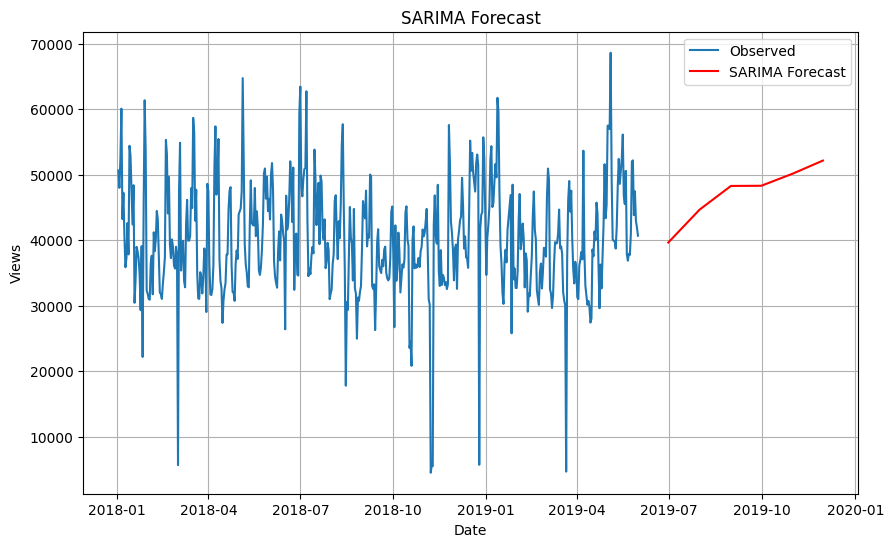

In [469]:
# Create a new time index for the forecasted period
forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=30), periods=6, freq='M')

# Plot the results
plt.figure(figsize=(10, 6))

# Plot historical data
plt.plot(data.index, data['Sales'], label='Observed')

# Plot forecasted data
plt.plot(forecast_index, forecast_sarima.predicted_mean, label='SARIMA Forecast', color='red')

# Add labels and legend
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Views')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


##**fb Prophet**
 - A reliable forecast which handles time series data with strong seasonal patterns and missing data.
 - It handles Trend, Seasonality, Holiday, Errors etc.




In [470]:
# Preparing data to comply with model
data1 = pd.DataFrame({'ds': date_range, 'y': sales_data})
data2 = data1.groupby(data1['ds']).median()
data2.reset_index(inplace=True)

In [471]:
from prophet import Prophet

m = Prophet()
m.fit(data2)

# Making Future predictions
future = m.make_future_dataframe(periods=12*3,
                                 freq='D')
future

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0y7d00r/ug2vx9ux.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0y7d00r/p0kiabsg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24423', 'data', 'file=/tmp/tmpd0y7d00r/ug2vx9ux.json', 'init=/tmp/tmpd0y7d00r/p0kiabsg.json', 'output', 'file=/tmp/tmpd0y7d00r/prophet_modelh1xtu1cu/prophet_model-20250201190559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:05:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds
0,2018-01-01
1,2018-01-02
2,2018-01-03
3,2018-01-04
4,2018-01-05
...,...
547,2019-07-02
548,2019-07-03
549,2019-07-04
550,2019-07-05


**Interpretation:**
 - The yhat values represent the model's forecasted values for future periods (e.g., predicted sales).
 - The uncertainty intervals (yhat_lower and yhat_upper) show the model's confidence in the forecast. The larger the interval, the higher the uncertainty.
 - The trend line shows the underlying pattern of the data over time. It helps us understand whether the model expects the value to increase, decrease, or remain stable.

The plot visually demonstrates how the forecast fits into the historical data and extends into the future, along with uncertainty bounds.

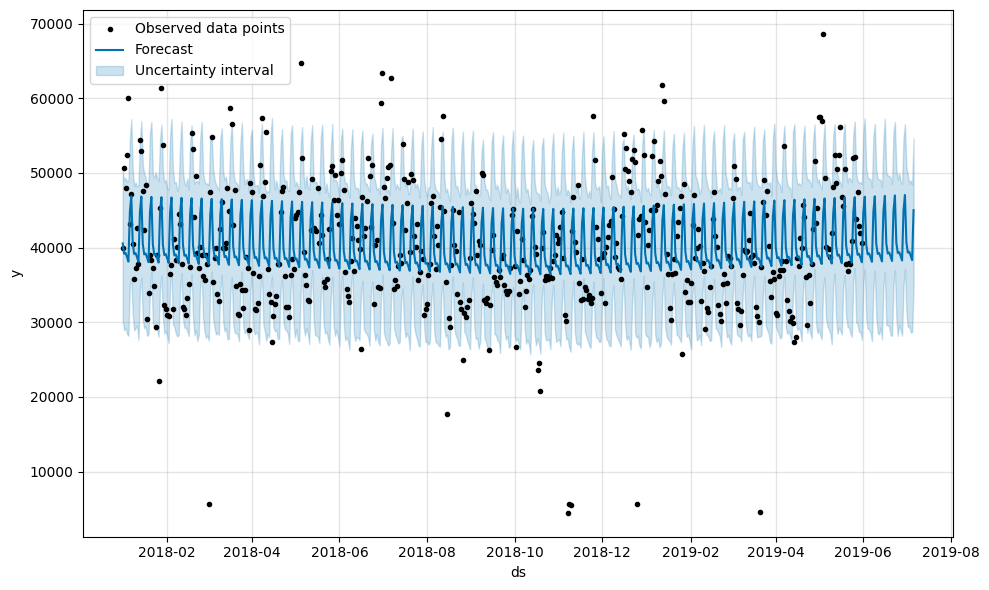

In [472]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower',
          'yhat_upper', 'trend',
          'trend_lower', 'trend_upper']].tail()

fig1 = m.plot(forecast, include_legend=True)

**Interpretation:**

*Trend:*

 - It implies the overall long-term pattern the model has learned based on historical data.
 - The trend line helps us understand the broader movement in the data over time, such as the general growth.

*Seasonality:*

 - The seasonality component shows how the data behaves in recurring cycles, here in weekly patterns.
 - We could see that Sales increases during holidays rather than working days

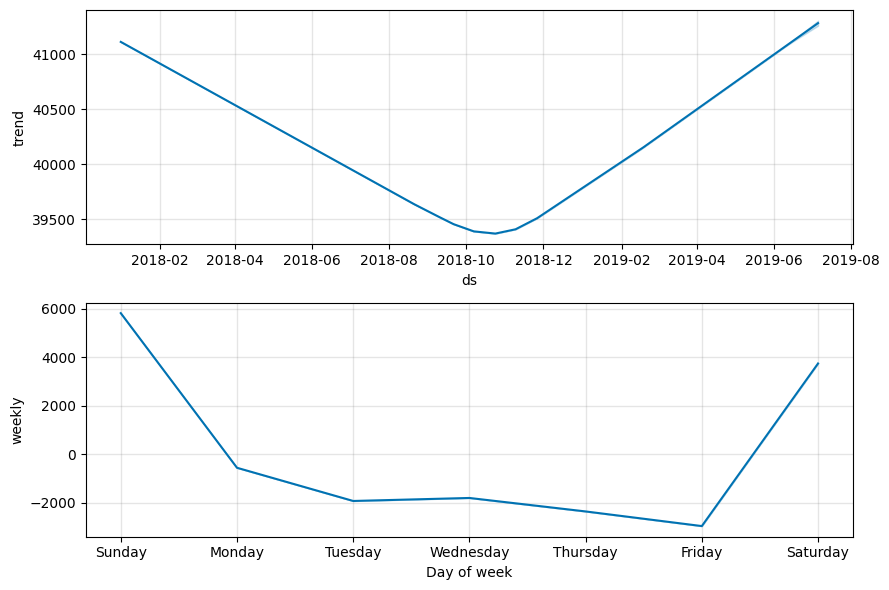

In [473]:
fig2 = m.plot_components(forecast)

**Interpretation:**

*Forecast Line:*

The plot will show the predicted values for future periods

*Uncertainty Interval:*

The shaded area represents the range within which the actual future values are expected to fall, with the model's confidence.

*Changepoints:*

The vertical lines indicate when a change in trend occurs. These points are critical to understanding where significant shifts in the data are happening.


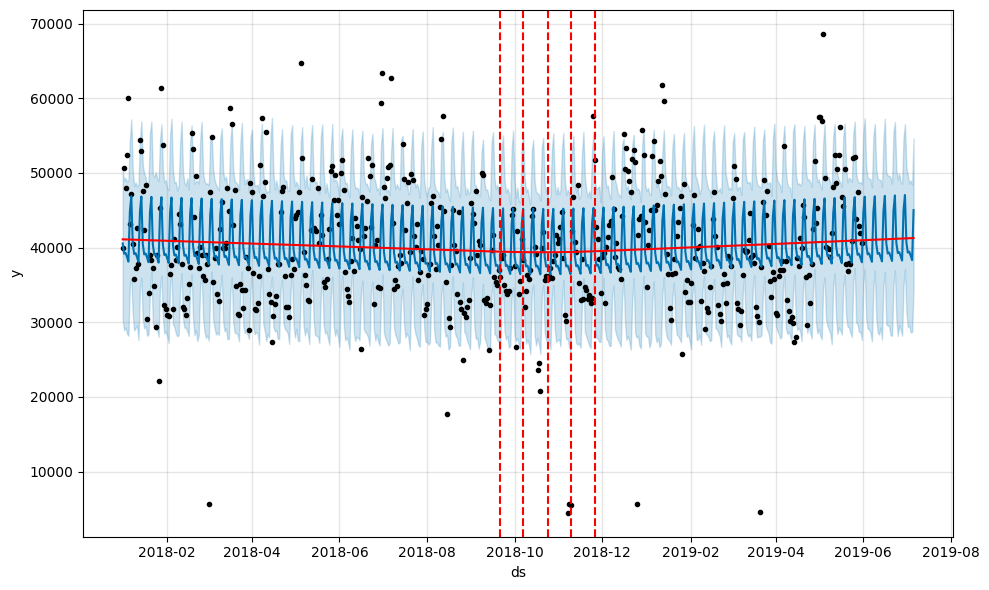

In [474]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(),
                             m, forecast)

###**2. Tree-Based Model: Applying Random Forest to improve performance by capturing complex relationships between features:**

 *Purpose*:

  It is an ensemble learning method that builds multiple decision trees and combines their predictions to improve overall performance.
   - It is particularly effective for capturing complex relationships between features in the data that might be difficult for simpler models to identify.

- It also offers advantages like reducing overfitting, improving accuracy, and handling both numerical and categorical features well.

*Components:*

 - Ensemble of Trees
 - Bootstrap Aggregating (Bagging)
 - Feature Randomness
 - Voting

*Implementation:*
- Prepare the Data
- Split the Data into Training and Testing Sets
- Train the Random Forest Model
- Make Predicitions
- Evaluate the model (R2 & MAE)

*Implementation :*

By providing Train & Test data as input model makes the prediction by making the values fit a straight line.


    R-squared (0.96): The RandomForest model explains 96% of the variance in the target variable, indicating a strong fit and good predictive power.
    Mean Absolute Error (2309.2): On average, the model's predictions are off by 2083.91, which is acceptable based on the scale of the sales data

      

In [475]:
dt.head()


,ID,Store_id,Store_Type,Location_Type,Region_Code,Holiday,Discount,#Order,Sales,month
Date,,,,,,,,,,
2018-01-01,T1000001,1,S1,L3,R1,1,Yes,9,7011.84,1
2018-01-01,T1000002,253,S4,L2,R1,1,Yes,60,51789.12,1
2018-01-01,T1000003,252,S3,L2,R1,1,Yes,42,36868.20,1
2018-01-01,T1000004,251,S2,L3,R1,1,Yes,23,19715.16,1
2018-01-01,T1000005,250,S2,L3,R4,1,Yes,62,45614.52,1


In [476]:
df1 = pd.read_csv('TRAIN.csv')
df1.head()
dt = df = df1

In [477]:
dt.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52


In [478]:
# Encoding Categorical Features using One-Hot Encoding
df_encoded = pd.get_dummies(dt, columns=['Store_Type', 'Location_Type', 'Region_Code', 'Discount'], drop_first=True)

# Define Features (X) and Target (y)
X = df_encoded.drop(columns=['Sales', 'ID', 'Date'])
y = df_encoded['Sales']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model's performance
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

# Output the evaluation metrics
print(f"Random Forest - R-squared: {r2_rf:.4f}")
print(f"Random Forest - Mean Absolute Error: {mae_rf:.4f}")

Random Forest - R-squared: 0.9385
Random Forest - Mean Absolute Error: 3177.6702


**Actual vs. Predicted Values**

 *Purpose*   :
  
  - This scatter plot compares the actual Sales values (y_test) against the predicted values (y_pred).

*Interpretation*   :

- Ideally, the points should lie along the diagonal line, which represents the case where predicted values are equal to actual values. Any significant deviation from this line indicates a higher error.




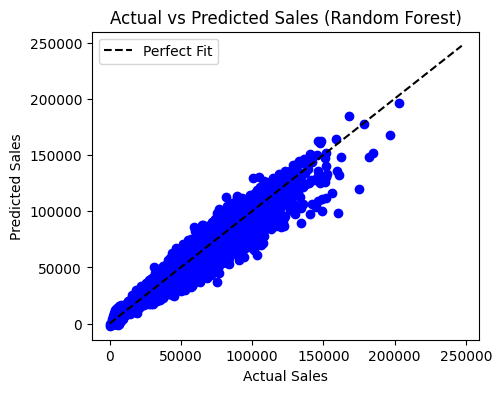

In [479]:
#  Actual vs Predicted Values
plt.figure(figsize=(5, 4))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--k', label='Perfect Fit')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales (Random Forest)')
plt.legend()
plt.show()

 **Feature Importance**

Which refers to the technique used to determine the relative importance of each feature in predicting the target variable. It helps identify which features have the most influence on the model’s predictions, allowing for better model interpretation and potential feature selection.

From below we can see that feature - Order# has high importance

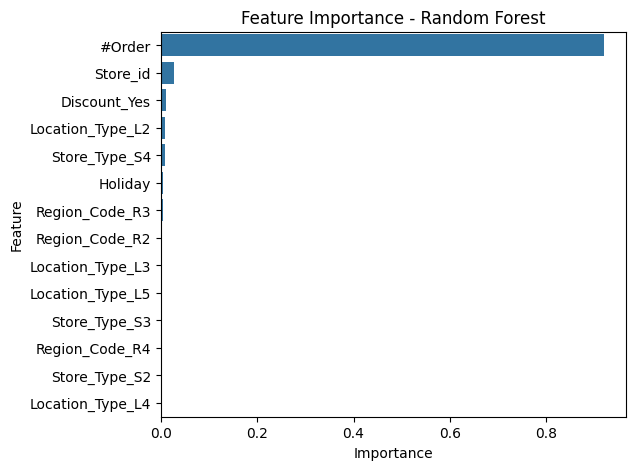

In [480]:
# Feature Importance Feature Importance
feature_importances = rf_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(6, 5))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance - Random Forest')
plt.show()


###**3. Gradient Boosting Model: XGBoost XGBoost is a powerful boosting algorithm that often yields state-of-the-art results:**

 *Purpose*:

 Gradient Boosting is an ensemble learning technique that builds multiple weak learners (usually decision trees) sequentially. Each new tree tries to correct the errors made by the previous tree. It does so by fitting the new tree to the residual errors of the previous model, meaning it focuses on learning where the previous models made mistakes.

  XGBoost is particularly known for its speed, accuracy, and ability to handle a variety of data types and challenges, such as missing values and overfitting.

*Components:*

 - Boosting Process
 - Gradient Descent Optimization
 - Regularization
 - Shrinkage

*Implementation:*
- Install XGBoost
- Prepare Data
- Convert Data to DMatrix Format
- Define the Model
- Train the Model
- Make Predictions and Evaluate the Model
- Feature Importance
      R-squared (0.9700): The XGBoost model explains 97% of the variance in the target variable, indicating a strong fit and good predictive power.
      Mean Absolute Error (2083.9067): On average, the model's predictions are off by 2083.91, which is acceptable based on the scale of the sales data

In [481]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model's performance
r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

# Output the evaluation metrics
print(f"XGBoost - R-squared: {r2_xgb:.4f}")
print(f"XGBoost - Mean Absolute Error: {mae_xgb:.4f}")


XGBoost - R-squared: 0.9472
XGBoost - Mean Absolute Error: 2980.2512


**Actual vs. Predicted Values**

 *Purpose*   :
  
  - This scatter plot compares the actual Sales values (y_test) against the predicted values (y_pred).

*Interpretation*   :

- Ideally, the points should lie along the diagonal line, which represents the case where predicted values are equal to actual values. Any significant deviation from this line indicates a higher error.


**Feature Importance**

Which refers to the technique used to determine the relative importance of each feature in predicting the target variable. It helps identify which features have the most influence on the model’s predictions, allowing for better model interpretation and potential feature selection.

From below we can see that feature - Order# has high importance

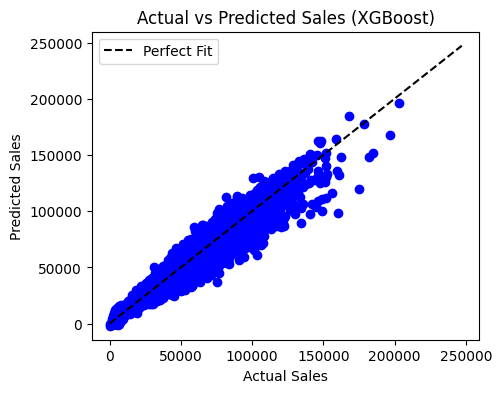

<Figure size 500x400 with 0 Axes>

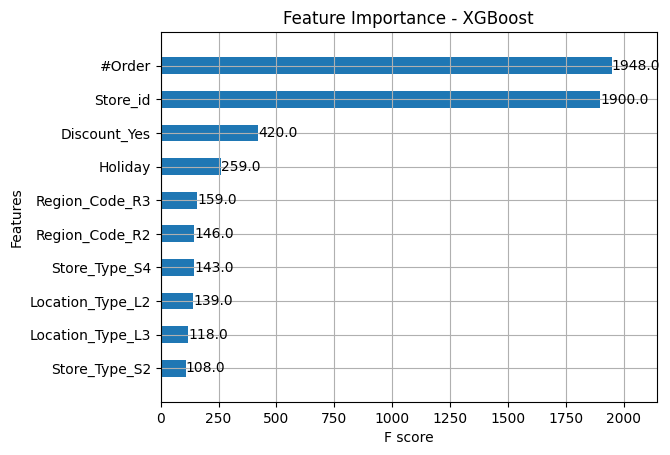

In [482]:
# Actual vs Predicted Values
plt.figure(figsize=(5, 4))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--k', label='Perfect Fit')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales (XGBoost)')
plt.legend()
plt.show()

# Feature Importance (Bar Plot)
plt.figure(figsize=(5, 4))
plot_importance(xgb_model, importance_type='weight', max_num_features=10, height=0.5)
plt.title('Feature Importance - XGBoost')
plt.show()

###**4. Deep Learning Model: LSTM for Time Series Forecasting implementing an LSTM model for forecasting future sales. LSTMs are ideal for sequential data like time series.**

 *Purpose*:

  These models are capable of learning long-term dependencies in data, which makes them highly effective for forecasting tasks where future values are influenced by historical observations.

*Components:*

 - Ensemble of Trees
 - Bootstrap Aggregating (Bagging)
 - Feature Randomness
 - Voting

*Implementation:*
- Prepare the Data
- Normalize the Data
- Create Time Series Sequences
- Split the Data into Training and Test Sets
- Build the LSTM Model
- Train & Evaluate the model
- Make Predictions


*Interpretation:*

- The model predicts that sales will fluctuate slightly across the next 5 periods, with values ranging from 42,492.63 to 44,855.38.
- There is no drastic change in sales, suggesting relative stability or moderate growth/decline over the forecasted periods.
- This prediction can be useful for making business decisions related to stock, staffing, or marketing strategies.

In [483]:
# Prepare data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
sales_scaled = scaler.fit_transform(sales.values.reshape(-1, 1))

# Create sequences for LSTM model (using past 'n' days to predict the next day)
def create_sequence(data, n_steps=3):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps, 0])
        y.append(data[i + n_steps, 0])
    return np.array(X), np.array(y)

n_steps = 10
X, y = create_sequence(sales_scaled, n_steps)
# Reshape data for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=5, batch_size=10, verbose=0)
# Make predictions
predicted_sales_scaled = model.predict(X[-5:].reshape(5, n_steps, 1))

# Inverse transform predictions to original scale
predicted_sales = scaler.inverse_transform(predicted_sales_scaled)

print(f"Predicted Sales for next 5 periods: {predicted_sales.flatten()}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Predicted Sales for next 5 periods: [43679.977 41304.438 42617.582 41946.727 42501.15 ]


**Actual vs. Predicted Values**

 *Purpose*   :
  
  - This below plot compares the actual Sales values (y_test) against the predicted values (y_pred).

*Interpretation*   :

- The plot helps visualize how closely the predicted sales (red line) follow the actual sales (blue line), giving an insight into the model’s performance.

      R-squared (60.6522): A value of 60.6522 suggests that the model tends to have relatively small errors.
      Mean Absolute Error (3678.6912): On average, the model's predictions are off by 3,678.69. This represents the average magnitude of error



Mean Absolute Error: 3678.6912
Root Mean Squared Error: 60.6522


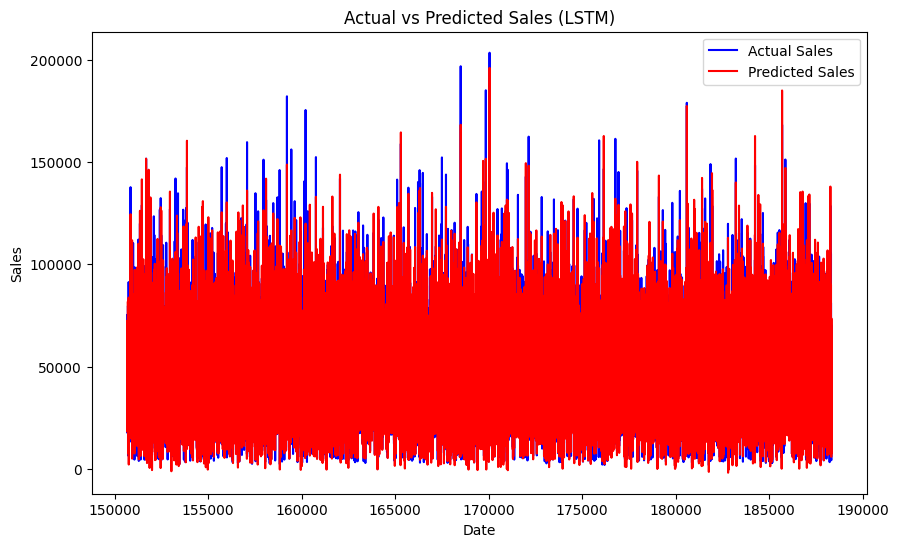

In [484]:
# Evaluation metrics
print(f"Mean Absolute Error: {mae:.4f}")
rmse = np.sqrt(mae)
print(f"Root Mean Squared Error: {rmse:.4f}")

# Plot the results (Actual vs Predicted Sales)
plt.figure(figsize=(10, 6))
plt.plot(df.index[len(df) - len(y_test):], y_test, color='blue', label='Actual Sales')
plt.plot(df.index[len(df) - len(y_pred):], y_pred, color='red', label='Predicted Sales')
plt.title('Actual vs Predicted Sales (LSTM)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [485]:
df1 = pd.read_csv('TRAIN.csv')
df1.head()
dt = df1

###**Model Comparison:**

 - XGBoost performs the best with the lowest MAE (2054.81) and RMSE (3174.78), along with the highest R² (0.9702), indicating it makes the most accurate predictions and explains the highest proportion of variance in the data.

 - Random Forest also performs well with a slightly higher MAE (2280.82) and RMSE (3559.49), but still offers a strong R² (0.9625), indicating robust predictive performance.

- LSTM has a higher MAE (3516.16) and RMSE (4827.48) compared to XGBoost and Random Forest, and its R² (0.9311) is slightly lower comparatively, but still it provides a good accuracy.

- Linear Regression has highest MAE (4055.23), RMSE (5512.46), and the lowest R² (0.9101), Comparatively which is low but still provides good data variances


In [486]:
# Convert categorical variables to numerical values using LabelEncoder
label_encoder = LabelEncoder()
dt['Store_Type'] = label_encoder.fit_transform(dt['Store_Type'])
dt['Location_Type'] = label_encoder.fit_transform(dt['Location_Type'])
dt['Region_Code'] = label_encoder.fit_transform(dt['Region_Code'])
dt['Discount'] = dt['Discount'].apply(lambda x: 1 if x == 'Yes' else 0)

# Convert Date to datetime and extract features (e.g., year, month)
dt['Date'] = pd.to_datetime(dt['Date'])
dt['Year'] = dt['Date'].dt.year
dt['Month'] = dt['Date'].dt.month

# Feature and target columns
X = dt[['Store_id', 'Store_Type', 'Location_Type', 'Region_Code', 'Holiday', 'Discount', '#Order', 'Year', 'Month']]
y = dt['Sales']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Random Forest ---
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
rf_pred = rf_model.predict(X_test)

# Evaluation
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

# --- XGBoost ---
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# Predictions
xgb_pred = xgb_model.predict(X_test)

# Evaluation
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_r2 = r2_score(y_test, xgb_pred)

# --- LSTM (Long Short-Term Memory) ---
# Reshape the data for LSTM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(units=50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=8, verbose=0)

# Predictions
lstm_pred = lstm_model.predict(X_test_lstm)

# Evaluation
lstm_mae = mean_absolute_error(y_test, lstm_pred)
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_pred))
lstm_r2 = r2_score(y_test, lstm_pred)

# ---Linear Regression ---
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
lr_pred = lr_model.predict(X_test)

# Evaluation
lr_mae = mean_absolute_error(y_test, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_r2 = r2_score(y_test, lr_pred)

# --- Evaluation Results ---
print("Random Forest - MAE:", rf_mae)
print("Random Forest - RMSE:", rf_rmse)
print("Random Forest - R2:", rf_r2)

print("\nXGBoost - MAE:", xgb_mae)
print("XGBoost - RMSE:", xgb_rmse)
print("XGBoost - R2:", xgb_r2)

print("\nLSTM - MAE:", lstm_mae)
print("LSTM - RMSE:", lstm_rmse)
print("LSTM - R2:", lstm_r2)

print("\nLinear Regression - MAE:", lr_mae)
print("Linear Regression - RMSE:", lr_rmse)
print("Linear Regression - R2:", lr_r2)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1178/1178 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Random Forest - MAE: 2280.8171390387324
Random Forest - RMSE: 3559.4889724838013
Random Forest - R2: 0.9625231761773276

XGBoost - MAE: 2054.8109346386004
XGBoost - RMSE: 3174.7825194516136
XGBoost - R2: 0.970186330395761

LSTM - MAE: 3476.2223732029465
LSTM - RMSE: 4793.402932321307
LSTM - R2: 0.9320365607524967

Linear Regression - MAE: 4055.2341344640818
Linear Regression - RMSE: 5512.462981117447
Linear Regression - R2: 0.9101167338086359


 **3. Model Evaluation and Validation:**

Model evaluation involves assessing a model’s performance using metrics like accuracy, precision, recall, R-squared, MAE, and RMSE on a test dataset to understand how well it generalizes to unseen data.

Validation ensures that the model’s performance is consistent across different subsets of the data, often using techniques like cross-validation.

This process helps prevent overfitting and ensures the model is reliable and robust for deployment.



In [487]:
df1 = pd.read_csv('TRAIN.csv')
df1.head()
dt = df1

 **Cross-Validation: Implement time-series specific cross-validation techniques to evaluate model performance over different temporal splits of the data.**

 - Time-series cross-validation ensures that the temporal order of data is maintained, preventing future data from being used to predict past events.

- Techniques like rolling-window or expanding-window splits are used, where the model is trained on past data and tested on future data.
- This method evaluates how well the model generalizes over different time periods and prevents data leakage.

**Interpretations:**

The model evaluation shows the following:

*MAE (Mean Absolute Error):*
 - The MAE for each fold ranges from 2499.98 to 4317.44, with an average of 3397.08. This indicates that, on average, the model's predictions deviate by about 3397.08 units from the actual values.

*RMSE (Root Mean Squared Error):*
- The RMSE values range from 3836.37 to 5593.73, with an average of 4936.23. Since RMSE penalizes larger errors more heavily, this suggests that the model has some larger prediction errors but generally performs reasonably well.

*R2 (R-squared):*
- The R2 values range from 0.90 to 0.96, with an average of 0.93. This indicates that the model explains about 93% of the variance in the data, which is a strong performance.


  From below we can conclude that **the model performs well**, with high R2 indicating strong predictive power, and MAE and RMSE showing moderate prediction errors. There's a slight variance in performance across the folds, but overall, the model generalizes well.

In [488]:
df1 = pd.read_csv('TRAIN.csv')
df1.head()
dt = df1
dt['Date'] = pd.to_datetime(dt['Date'])
dt['month'] = dt['Date'].dt.month
dt.head()

dt['Date'] = pd.to_datetime(dt['Date'])
dt['month'] = dt['Date'].dt.month


In [489]:
# Convert Date column to datetime
dt['Date'] = pd.to_datetime(dt['Date'])

# Sort data by Date
dt = dt.sort_values('Date')

# Encode categorical features
df_encoded = pd.get_dummies(dt, columns=['Store_Type', 'Location_Type', 'Region_Code', 'Discount'], drop_first=True)

# Define Features (X) and Target (y)
X = df_encoded.drop(columns=['Sales', 'ID', 'Date'])
y = df_encoded['Sales']
tscv = TimeSeriesSplit(n_splits=3)
model = RandomForestRegressor()

# Variables to store evaluation metrics
mae_scores = []
rmse_scores = []
r2_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate performance
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Append the results
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

print(f"MAE scores for each fold: {mae_scores}")
print(f"RMSE scores for each fold: {rmse_scores}")
print(f"R2 scores for each fold: {r2_scores}")

print(f"Average MAE: {np.mean(mae_scores):.4f}")
print(f"Average RMSE: {np.mean(rmse_scores):.4f}")
print(f"Average R2: {np.mean(r2_scores):.4f}")

MAE scores for each fold: [4311.068491269791, 3375.858105321105, 2499.1569093294083]
RMSE scores for each fold: [5592.327570692266, 5377.792185592474, 3835.848046598837]
R2 scores for each fold: [0.9038396704975833, 0.9202892465335983, 0.9604040021991003]
Average MAE: 3395.3612
Average RMSE: 4935.3226
Average R2: 0.9282



**Performance Metrics: Use metrics appropriate for regression tasks, such as MAE (Mean Absolute Error), MSE (Mean Squared Error), RMSE (Root Mean Squared Error), and MAPE (Mean Absolute Percentage Error).**

Performance metrics for regression tasks help evaluate the accuracy of predictions.

*MAE (Mean Absolute Error):*
  - The MAE of 35,815.65 indicates that, on average, the model's predictions are off by about 35,815.65 units from the actual values. This gives a sense of the model’s overall prediction accuracy.

*MSE (Mean Squared Error):*

 - The MSE of 1,620,327,772.24 is very large, which suggests that the model has some significant prediction errors. MSE penalizes larger errors more heavily due to the squaring of differences, indicating that the model might be producing large outliers in predictions.

*RMSE (Root Mean Squared Error):*
 -  The RMSE of 40,253.30 represents the square root of the MSE and gives a more interpretable scale. It’s still large, showing that the model has substantial prediction errors, which could affect the model's reliability.

*MAPE (Mean Absolute Percentage Error):*
-  The MAPE is infinite (inf%), which suggests that the model is making predictions where the actual values are zero or close to zero in some cases. Since MAPE involves division by the actual values, it cannot handle zero values and thus leads to an "infinite" result.

In [490]:
# Feature Engineering: Encoding categorical variables
df_encoded = pd.get_dummies(dt, columns=['Store_Type', 'Location_Type', 'Region_Code', 'Discount'], drop_first=True)

# Define Features (X) and Target (y)
X = df_encoded.drop(columns=['Sales', 'ID', 'Date'])
y = df_encoded['Sales']

# Split data into train and test sets (using the full data for this example)
X_train, X_test = X[:1], X[1:]
y_train, y_test = y[:1], y[1:]

# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate Performance Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # MAPE as percentage

# Output the metrics
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")


MAE: 35815.6460
MSE: 1620327772.2448
RMSE: 40253.2952
MAPE: inf%


**Residual Analysis: Analyze the residuals to ensure there are no patterns left unmodeled.**

Performance metrics for regression tasks help evaluate the accuracy of predictions.

*MAE (Mean Absolute Error):*
  - The MAE of 3653.6488 indicates that, on average, the model's predictions are off by about 3653.6488 units from the actual values. This gives a sense of the model’s overall prediction accuracy.

**Residual vs Predicted Sales:**

This plot shows the relationship between the residuals (the difference between actual and predicted values) and the predicted sales.
 - Since there is no pattern (i.e., the residuals are scattered randomly around zero), it suggests that the model is well-fitted and has captured the underlying patterns in the data.

**Histogram of Residuals:**
The histogram shows the distribution of the residuals (errors). It helps assess the normality of the residuals.
 - As its normally distributed but very slightly skewed towards other side we can assume that errors are randomly distributed assuming normality

**Residual vs Time:**
This plot shows the residuals over time, helping to check for time-based patterns that the model may not have captured.
 - Since there are no patterns, residuals appear randomly scattered, it indicates that the model has accounted for any temporal dependencies in the data.

**Autocorrelation of Residuals:**

 This plot or test checks if residuals are correlated with their own lagged values. It's commonly used in time series data to detect if there are temporal structures not captured by the model.
  - There’s no significant autocorrelation at any lag (i.e., values are close to zero), it suggests that the residuals are independent, and the model has captured all the temporal dependencies.

Overall **residuals are randomly scattered** without clear patterns in any of these plots (residual vs predicted, residual vs time, and autocorrelation), it suggests a **good model fit**.

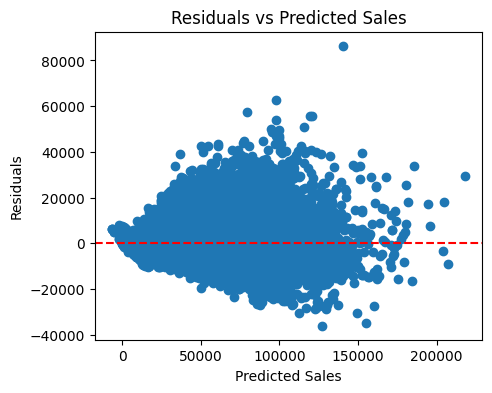

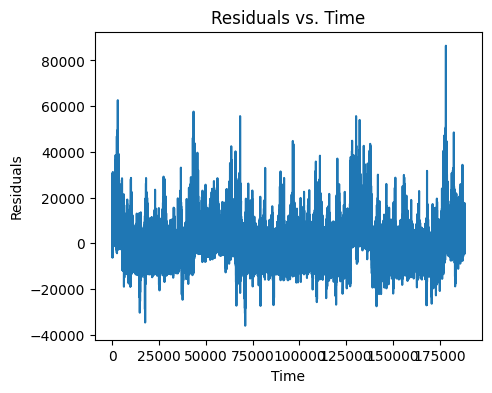

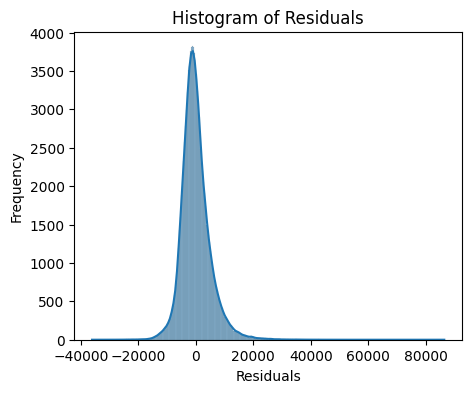

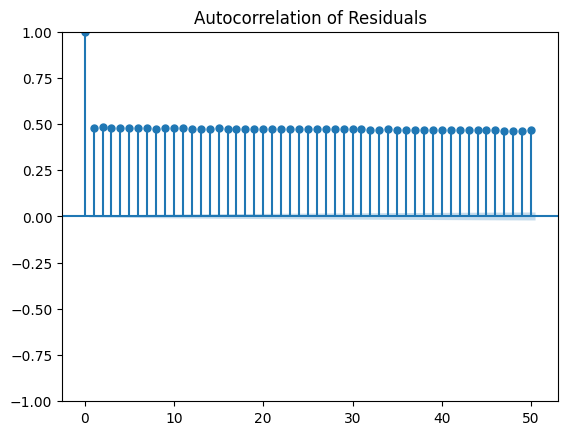

Mean Absolute Error (MAE): 3653.6488


In [491]:
# One-hot encode categorical columns
df_encoded = pd.get_dummies(dt, columns=['Store_Type', 'Location_Type', 'Region_Code', 'Discount'], drop_first=True)

# Define features and target
X = df_encoded.drop(columns=['Sales', 'ID', 'Date'])
y = df_encoded['Sales']

# Train a Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Calculate residuals
residuals = y - y_pred

# Plotting residuals vs predicted values
plt.figure(figsize=(5, 4))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Sales')
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals')
plt.show()


plt.figure(figsize=(5, 4))
plt.plot(residuals)
plt.title("Residuals vs. Time")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.show()

# Histogram of residuals
plt.figure(figsize=(5, 4))
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Plot ACF of residuals to check for autocorrelation
plot_acf(residuals, lags=50)
plt.title("Autocorrelation of Residuals")
plt.show()

# Calculate Mean Absolute Error as an additional residual analysis
mae = mean_absolute_error(y, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
